# DOMAIN ADVERSARIAL NEURAL NETWORK
## FROM [pumpikano](https://github.com/pumpikano/tf-dann)

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import cPickle as pkl
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import urllib
import os
import tarfile
import skimage
import skimage.io
import skimage.transform
%matplotlib inline
print ("PACKAGES LOADED")

PACKAGES LOADED


## DOWNLOAD BSR_bsds500.tgz

In [2]:
filelink = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
filename = 'data/BSR_bsds500.tgz'
if os.path.isfile(filename):
    print ("[%s] ALREADY EXISTS." % (filename))
else:
    print ("DOWNLOADING %s ..." % (filename))
    urllib.urlretrieve(filelink, filename)
    print ("DONE")

[data/BSR_bsds500.tgz] ALREADY EXISTS.


## CREATE MNIST-M

### HELPER FUNCTIONS

In [3]:
def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)
    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)
def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)
def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):
        bg_img = rand.choice(background_data)
        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d
    return X_
print ("FUNCTIONS READY")

FUNCTIONS READY


### CREATE MNIST-M DATASET (IF NECESSARY)

In [4]:
mnistm_name = 'data/mnistm.pkl'
if os.path.isfile(mnistm_name):
    print ("[%s] ALREADY EXISTS. " % (mnistm_name))
else:
    mnist = input_data.read_data_sets('data')
    # OPEN BSDS500
    f = tarfile.open(filename)
    train_files = []
    for name in f.getnames():
        if name.startswith('BSR/BSDS500/data/images/train/'):
            train_files.append(name)
    print ("WE HAVE [%d] TRAIN FILES" % (len(train_files)))
    # GET BACKGROUND
    print ("GET BACKGROUND FOR MNIST-M")
    background_data = []
    for name in train_files:
        try:
            fp = f.extractfile(name)
            bg_img = skimage.io.imread(fp)
            background_data.append(bg_img)
        except:
            continue
    print ("WE HAVE [%d] BACKGROUND DATA" % (len(background_data)))
    rand = np.random.RandomState(42)
    print ("BUILDING TRAIN SET...")
    train = create_mnistm(mnist.train.images)
    print ("BUILDING TEST SET...")
    test = create_mnistm(mnist.test.images)
    print ("BUILDING VALIDATION SET...")
    valid = create_mnistm(mnist.validation.images)
    # SAVE
    print ("SAVE MNISTM DATA TO %s" % (mnistm_name))
    with open(mnistm_name, 'w') as f:
        pkl.dump({ 'train': train, 'test': test, 'valid': valid }, f, -1)
    print ("DONE")

[data/mnistm.pkl] ALREADY EXISTS. 


## LOAD MNIST AND MNIST-M 

LOADING MNIST
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
LOADING MNIST-M
GENERATING DOMAIN DATA


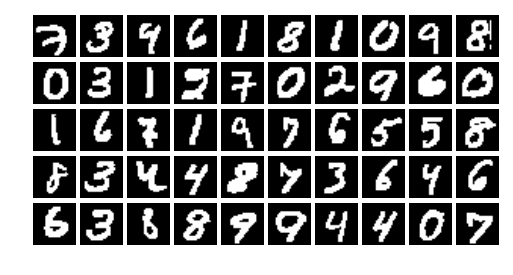

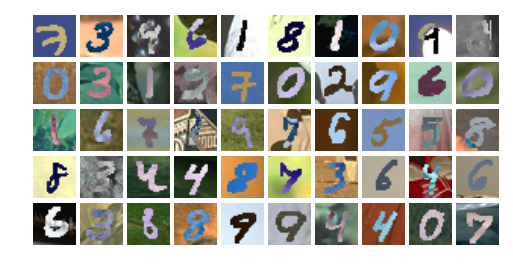

In [5]:
print ("LOADING MNIST")
mnist        = input_data.read_data_sets('data', one_hot=True)
mnist_train  = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train  = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test   = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test   = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
mnist_train_label = mnist.train.labels
mnist_test_label = mnist.test.labels
print ("LOADING MNIST-M")
mnistm_name  = 'data/mnistm.pkl'
mnistm       = pkl.load(open(mnistm_name))
mnistm_train = mnistm['train']
mnistm_test  = mnistm['test']
mnistm_valid = mnistm['valid']
mnistm_train_label = mnist_train_label
mnistm_test_label = mnist_test_label
print ("GENERATING DOMAIN DATA")

total_train        = np.vstack([mnist_train, mnistm_train])
total_test         = np.vstack([mnist_test, mnistm_test])
ntrain             = mnist_train.shape[0]
ntest              = mnist_test.shape[0]
total_train_domain = np.vstack([np.tile([1., 0.], [ntrain, 1]), np.tile([0., 1.], [ntrain, 1])])
total_test_domain  = np.vstack([np.tile([1., 0.], [ntest, 1]), np.tile([0., 1.], [ntest, 1])])
n_total_train      = total_train.shape[0]
n_total_test       = total_test.shape[0]

# GET PIXEL MEAN 
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

# PLOT IMAGES
def imshow_grid(images, shape=[2, 8]):
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure()
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)
    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i]) 
    plt.show()
imshow_grid(mnist_train, shape=[5, 10])
imshow_grid(mnistm_train, shape=[5, 10])

## CHECK SHAPE

In [6]:
def print_npshape(x, name):
    print ("SHAPE OF %s IS %s" % (name, x.shape,))
print_npshape(total_train,        "total_train")
print_npshape(total_test,         "total_test")
print_npshape(total_train_domain, "total_train_domain")
print_npshape(total_test_domain,  "total_test_domain")

SHAPE OF total_train IS (110000, 28, 28, 3)
SHAPE OF total_test IS (20000, 28, 28, 3)
SHAPE OF total_train_domain IS (110000, 2)
SHAPE OF total_test_domain IS (20000, 2)


## FLIP GRADIENT

In [7]:
class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0
    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient%d" % self.num_calls
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.neg(grad) * l]
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
        self.num_calls += 1
        return y
flip_gradient = FlipGradientBuilder()

## BUILD MODEL

In [8]:
x  = tf.placeholder(tf.uint8, [None, 28, 28, 3])
y  = tf.placeholder(tf.float32, [None, 10])
d  = tf.placeholder(tf.float32, [None, 2]) # DOMAIN LABEL
lr = tf.placeholder(tf.float32, [])
dw = tf.placeholder(tf.float32, [])
# FEATURE EXTRACTOR
def feat_ext_net(x, name='feat_ext', reuse=False):
    with tf.variable_scope(name) as scope:
        if reuse:
            scope.reuse_variables()
        x = (tf.cast(x, tf.float32) - pixel_mean) / 255.
        net = slim.conv2d(x, 32, [5, 5], scope = 'conv1')
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.conv2d(net, 48, [5, 5], scope='conv2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        feat = slim.flatten(net, scope='flat')
    return feat
# CLASS PREDICTION
def class_pred_net(feat, name='class_pred', reuse=False):
    with tf.variable_scope(name) as scope:
        if reuse:
            scope.reuse_variables()
        net = slim.fully_connected(feat, 100, scope='fc1')
        net = slim.fully_connected(net, 100, scope='fc2')
        net = slim.fully_connected(net, 10, activation_fn = None, scope='out')
    return net
# DOMAIN PREDICTION
def domain_pred_net(feat, name='domain_pred', reuse=False):
    with tf.variable_scope(name) as scope:
        if reuse:
            scope.reuse_variables()
        feat = flip_gradient(feat, dw) # GRADIENT REVERSAL
        net = slim.fully_connected(feat, 100, scope='fc1')
        net = slim.fully_connected(net, 2, activation_fn = None, scope='out')
    return net
# DOMAIN ADVERSARIAL NEURAL NETWORK
feat_ext_dann    = feat_ext_net(x, name='dann_feat_ext')
class_pred_dann  = class_pred_net(feat_ext_dann, name='dann_class_pred')
domain_pred_dann = domain_pred_net(feat_ext_dann, name='dann_domain_pred')
# NAIVE CONVOLUTIONAL NEURAL NETWORK
feat_ext_cnn     = feat_ext_net(x, name='cnn_feat_ext')
class_pred_cnn   = class_pred_net(feat_ext_cnn, name='cnn_class_pred')

print ("MODEL READY")

MODEL READY


## CHECK VARIABLES & SET WEIGHT DECAY

In [9]:
t_weights = tf.trainable_variables()
# TOTAL WEIGHTS
print ("   TOTAL WEIGHT LIST")
for i in range(len(t_weights)):
    print ("[%2d/%2d] [%s]" 
           % (i, len(t_weights), t_weights[i]))

# FEATURE EXTRACTOR + CLASS PREDICTOR 
print ("\n   WEIGHT LIST FOR CLASS PREDICTOR")
w_class = []
for i in range(len(t_weights)): 
    if t_weights[i].name[:9] == 'dann_feat' or t_weights[i].name[:10] == 'dann_class':
        w_class.append(tf.nn.l2_loss(t_weights[i]))
        print ("[%s]    \t ADDED TO W_CLASS LIST" % (t_weights[i].name))
l2loss_dann_class = tf.add_n(w_class)

# FEATURE EXTRACTOR + DOMAIN CLASSIFIER 
print ("\n   WEIGHT LIST FOR DOMAIN CLASSIFIER")
w_domain = []
for i in range(len(t_weights)):
    if t_weights[i].name[:8] == 'dann_feat' or t_weights[i].name[:11] == 'dann_domain':
        w_domain.append(tf.nn.l2_loss(t_weights[i]))
        print ("[%s]    \t ADDED TO W_DOMAIN LIST" % (t_weights[i].name))
l2loss_cnn_domain = tf.add_n(w_domain)

   TOTAL WEIGHT LIST
[ 0/24] [Tensor("dann_feat_ext/conv1/weights/read:0", shape=(5, 5, 3, 32), dtype=float32)]
[ 1/24] [Tensor("dann_feat_ext/conv1/biases/read:0", shape=(32,), dtype=float32)]
[ 2/24] [Tensor("dann_feat_ext/conv2/weights/read:0", shape=(5, 5, 32, 48), dtype=float32)]
[ 3/24] [Tensor("dann_feat_ext/conv2/biases/read:0", shape=(48,), dtype=float32)]
[ 4/24] [Tensor("dann_class_pred/fc1/weights/read:0", shape=(2352, 100), dtype=float32)]
[ 5/24] [Tensor("dann_class_pred/fc1/biases/read:0", shape=(100,), dtype=float32)]
[ 6/24] [Tensor("dann_class_pred/fc2/weights/read:0", shape=(100, 100), dtype=float32)]
[ 7/24] [Tensor("dann_class_pred/fc2/biases/read:0", shape=(100,), dtype=float32)]
[ 8/24] [Tensor("dann_class_pred/out/weights/read:0", shape=(100, 10), dtype=float32)]
[ 9/24] [Tensor("dann_class_pred/out/biases/read:0", shape=(10,), dtype=float32)]
[10/24] [Tensor("dann_domain_pred/fc1/weights/read:0", shape=(2352, 100), dtype=float32)]
[11/24] [Tensor("dann_domain_p

## DEFINE FUNCTIONS

In [10]:
# FUNCTIONS FOR DANN
class_loss_dann  = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(class_pred_dann, y)) 
domain_loss_dann = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(domain_pred_dann, d)) 
optm_class_dann  = tf.train.MomentumOptimizer(lr, 0.9).minimize(class_loss_dann)
optm_domain_dann = tf.train.MomentumOptimizer(lr, 0.9).minimize(domain_loss_dann)
accr_class_dann  = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(class_pred_dann, 1), tf.arg_max(y, 1)), tf.float32))
accr_domain_dann = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(domain_pred_dann, 1), tf.arg_max(d, 1)), tf.float32))

# FUNCTIONS FOR CNN
class_loss_cnn   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(class_pred_cnn, y)) 
optm_class_cnn   = tf.train.MomentumOptimizer(lr, 0.9).minimize(class_loss_cnn)
accr_class_cnn   = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(class_pred_cnn, 1), tf.arg_max(y, 1)), tf.float32))
print ("FUNCTIONS READY")

FUNCTIONS READY


## OPEN SESSION

In [11]:
sess = tf.Session()
tf.set_random_seed(0)
init = tf.global_variables_initializer()
sess.run(init)
print ("SESSION OPENED")

SESSION OPENED


## OPTIMIZE

In [12]:
# PARAMETERS
batch_size      = 128
training_epochs = 30
every_epoch     = 1
num_batch = int(ntrain/batch_size)+1
total_iter = training_epochs*num_batch
for epoch in range(training_epochs):
    randpermlist = np.random.permutation(ntrain)
    for i in range(num_batch): 
        # REVERSAL WEIGHT AND LEARNING RATE SCHEDULE
        curriter = epoch*num_batch + i
        p        = float(curriter) / float(total_iter)
        dw_val   = 2. / (1. + np.exp(-10. * p)) - 1
        lr_val   = 0.01 / (1. + 10 * p)**0.75
        
        # OPTIMIZE DANN: CLASS-CLASSIFIER
        randidx_class = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_x_class = mnist_train[randidx_class]
        batch_y_class = mnist_train_label[randidx_class, :]
        feeds_class = {x:batch_x_class, y:batch_y_class, lr:lr_val, dw:dw_val}
        _, lossclass_val_dann = sess.run([optm_class_dann, class_loss_dann], feed_dict=feeds_class)
        
        # OPTIMIZE DANN: DOMAIN-CLASSIFER
        randidx_domain = np.random.permutation(n_total_train)[:batch_size]
        batch_x_domain = total_train[randidx_domain]
        batch_d_domain = total_train_domain[randidx_domain, :]
        feeds_domain = {x:batch_x_domain, d:batch_d_domain, lr:lr_val, dw:dw_val}
        _, lossdomain_val_dann = sess.run([optm_domain_dann, domain_loss_dann], feed_dict=feeds_domain)
        
        # OPTIMIZE DANN: CLASS-CLASSIFIER
        _, lossclass_val_cnn = sess.run([optm_class_cnn, class_loss_cnn], feed_dict=feeds_class)
     
    if epoch % every_epoch == 0:
        # CHECK BOTH LOSSES
        print ("[%d/%d][%d/%d] p: %.3f lossclass_val: %.3e, lossdomain_val: %.3e" 
               % (epoch, training_epochs, curriter, total_iter, p, lossdomain_val_dann, lossclass_val_dann))
        # CHECK ACCUARACIES OF BOTH SOURCE AND TARGET
        feed_source = {x:mnist_test, y:mnist_test_label}
        feed_target = {x:mnistm_test, y:mnistm_test_label}
        accr_source_dann = sess.run(accr_class_dann, feed_dict=feed_source)
        accr_target_dann = sess.run(accr_class_dann, feed_dict=feed_target)
        accr_source_cnn = sess.run(accr_class_cnn, feed_dict=feed_source)
        accr_target_cnn = sess.run(accr_class_cnn, feed_dict=feed_target)
        print (" DANN: SOURCE (MNIST) ACCURACY: %.3f TARGET (MNIST-M) ACCURACY: %.3f" 
               % (accr_source_dann, accr_target_dann)) 
        print (" CNN: SOURCE (MNIST) ACCURACY: %.3f TARGET (MNIST-M) ACCURACY: %.3f" 
               % (accr_source_cnn, accr_target_cnn)) 

[0/30][429/12900] p: 0.033 lossclass_val: 1.730e-01, lossdomain_val: 4.193e-02
 DANN: SOURCE (MNIST) ACCURACY: 0.970 TARGET (MNIST-M) ACCURACY: 0.552
 CNN: SOURCE (MNIST) ACCURACY: 0.975 TARGET (MNIST-M) ACCURACY: 0.541
[1/30][859/12900] p: 0.067 lossclass_val: 2.095e-01, lossdomain_val: 4.448e-02
 DANN: SOURCE (MNIST) ACCURACY: 0.977 TARGET (MNIST-M) ACCURACY: 0.591
 CNN: SOURCE (MNIST) ACCURACY: 0.977 TARGET (MNIST-M) ACCURACY: 0.556
[2/30][1289/12900] p: 0.100 lossclass_val: 2.469e-01, lossdomain_val: 1.495e-02
 DANN: SOURCE (MNIST) ACCURACY: 0.983 TARGET (MNIST-M) ACCURACY: 0.616
 CNN: SOURCE (MNIST) ACCURACY: 0.984 TARGET (MNIST-M) ACCURACY: 0.570
[3/30][1719/12900] p: 0.133 lossclass_val: 1.465e-01, lossdomain_val: 4.939e-02
 DANN: SOURCE (MNIST) ACCURACY: 0.984 TARGET (MNIST-M) ACCURACY: 0.620
 CNN: SOURCE (MNIST) ACCURACY: 0.985 TARGET (MNIST-M) ACCURACY: 0.574
[4/30][2149/12900] p: 0.167 lossclass_val: 1.101e-01, lossdomain_val: 1.997e-01
 DANN: SOURCE (MNIST) ACCURACY: 0.963 

## CHECK ACCURACIES

In [13]:
feed_source = {x:mnist_test, y:mnist_test_label}
feed_target = {x:mnistm_test, y:mnistm_test_label}
accr_source_dann = sess.run(accr_class_dann, feed_dict=feed_source)
accr_target_dann = sess.run(accr_class_dann, feed_dict=feed_target)
accr_source_cnn = sess.run(accr_class_cnn, feed_dict=feed_source)
accr_target_cnn = sess.run(accr_class_cnn, feed_dict=feed_target)
print (" DANN: SOURCE (MNIST) ACCURACY: %.3f TARGET (MNIST-M) ACCURACY: %.3f" 
       % (accr_source_dann, accr_target_dann)) 
print (" CNN: SOURCE (MNIST) ACCURACY: %.3f TARGET (MNIST-M) ACCURACY: %.3f" 
       % (accr_source_cnn, accr_target_cnn)) 

 DANN: SOURCE (MNIST) ACCURACY: 0.981 TARGET (MNIST-M) ACCURACY: 0.726
 CNN: SOURCE (MNIST) ACCURACY: 0.988 TARGET (MNIST-M) ACCURACY: 0.575


## CHECK WITH T-SNE

In [14]:
# COMBINE SOURCE AND TARGET DATA
num_test = 500
comb_imgs   = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
comb_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
comb_domain = np.vstack([np.tile([1., 0.], [num_test, 1]), np.tile([0., 1.], [num_test, 1])])

# GET FEATURE REPRESENTATIONS
test_emb_dann = sess.run(feat_ext_dann, feed_dict={x: comb_imgs})
test_emb_cnn = sess.run(feat_ext_cnn, feed_dict={x: comb_imgs})

# RUN T-SNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne.fit_transform(test_emb_dann)
cnn_tsne  = tsne.fit_transform(test_emb_cnn)
print ("T-SNE DONE.")

T-SNE DONE.


### PLOT FUNCTION

In [15]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    # PLOT COLORED NUMBERS
    plt.figure(figsize=(10, 10)) 
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color = plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([]) # REMOVE TICKS
    xmean, xvar = np.mean(X, 0), np.var(X, 0)
    if title is not None:
        plt.title(title)

## PLOT REPRESENTATIONS WITH T-SNE

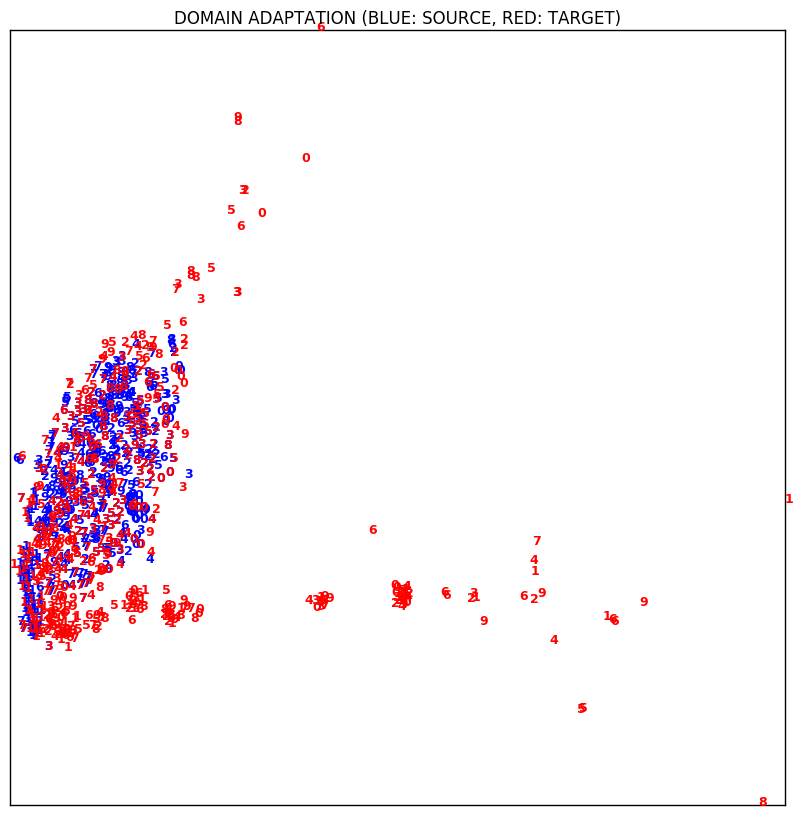

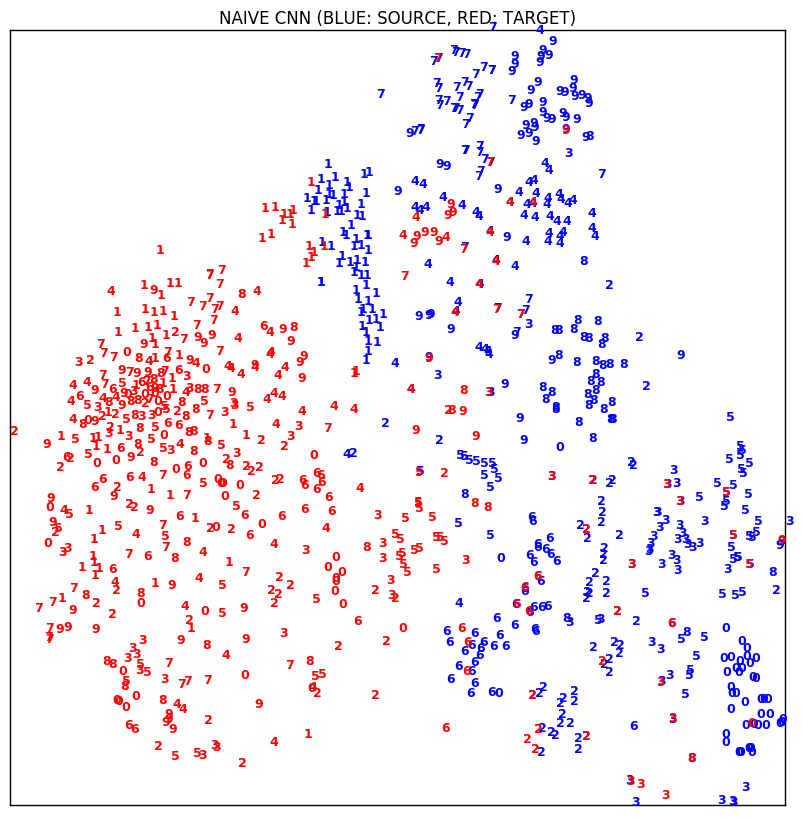

In [16]:
# 0: BLUE (SOURSE) 1: RED (TARGET) 
plot_embedding(dann_tsne, comb_labels.argmax(1), comb_domain.argmax(1)
               , 'DOMAIN ADAPTATION (BLUE: SOURCE, RED: TARGET)')
plot_embedding(cnn_tsne, comb_labels.argmax(1), comb_domain.argmax(1)
               , 'NAIVE CNN (BLUE: SOURCE, RED: TARGET)')